<a href="https://colab.research.google.com/github/nvb5140/CS583-Deep-Learning-NB/blob/main/HW/HW2/Programming2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment: Build a CNN for image recognition.

### Name: Nick Benelli


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accuracy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.


4. Upload the .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [2]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Training (train) and Testings (test) Sets:')
print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

170508288/170498071 [==============================] - 2s 0us/step
Training (train) and Testings (test) Sets:
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [3]:
def to_one_hot(y, num_class=10):
    '''
    Covnert integer classes in a one-hot encoding vector. i.e 3 = [0,0,0,1,0]

    Parameters
    ----------
    y : numpy.ndarray
        label vector.
    num_class : int, optional
        number of classes in multi-class classifcation. The default is 10.

    Returns
    -------
    y_one_hot : numpy.ndarray
        one-hot encoding matrix of y.

    '''
    y_one_hot = numpy.zeros((len(y), num_class))
    for i, y_i in enumerate(y):
        y_one_hot[i, y_i] = 1
    return y_one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [4]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Train (tr) and Validation (val) Sets:')
print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Train (tr) and Validation (val) Sets:
Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [5]:
# Model Hyperparameters
dropout_rate = 0.4

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential


# Model
model = Sequential()
# set 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# set 2
model.add(Dropout(dropout_rate))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# set 3
model.add(Dropout(dropout_rate))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# (final set)
model.add(Flatten())
model.add(Dropout(dropout_rate)) # before first dense layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))  # multi-class classifcation

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0

In [7]:
#from keras import optimizers
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Hyperparams
batch_size = 32
epochs = 30

# Data Augmentation 
rescale = 1./255
rotation_range = 40
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.2
horizontal_flip=True

# Model Parameters
learning_rate = 1E-3 # to be tuned!
loss='categorical_crossentropy'
rho=0.9
momentum=0.1
metrics = ['acc']

# Data Augmenation
train_datagen = ImageDataGenerator(
    rescale = rescale,
    rotation_range = rotation_range,
    width_shift_range = width_shift_range,
    height_shift_range = height_shift_range,
    shear_range = shear_range,
    zoom_range = zoom_range,
    horizontal_flip = horizontal_flip)

train_datagen.fit(x_tr)
train_generator = train_datagen.flow(x_tr, y_tr, batch_size=batch_size)
test_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=batch_size)

# Compile Model
model.compile(
    loss=loss,
    optimizer= optimizers.RMSprop(
        learning_rate= learning_rate,
        rho=rho,
        momentum=momentum),
    metrics = metrics
)


In [8]:
# Run the Model
history = model.fit(x_tr, y_tr, batch_size=32, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/30
1250/1250 [==============================] - 323s 257ms/step - loss: 1.5994 - acc: 0.4193 - val_loss: 1.3220 - val_acc: 0.5464
Epoch 2/30
1250/1250 [==============================] - 312s 249ms/step - loss: 1.1502 - acc: 0.5917 - val_loss: 2.4598 - val_acc: 0.3046
Epoch 3/30
1250/1250 [==============================] - 326s 261ms/step - loss: 0.9972 - acc: 0.6496 - val_loss: 0.9958 - val_acc: 0.6702
Epoch 4/30
1250/1250 [==============================] - 317s 254ms/step - loss: 0.9213 - acc: 0.6754 - val_loss: 0.8289 - val_acc: 0.7167
Epoch 5/30
1250/1250 [==============================] - 317s 254ms/step - loss: 0.8601 - acc: 0.7015 - val_loss: 1.0624 - val_acc: 0.6379
Epoch 6/30
1250/1250 [==============================] - 314s 251ms/step - loss: 0.8140 - acc: 0.7189 - val_loss: 0.7758 - val_acc: 0.7209
Epoch 7/30
1250/1250 [==============================] - 321s 257ms/step - loss: 0.7759 - acc: 0.7317 - val_loss: 0.7653 - val_acc: 0.7387
Epoch 8/30
1250/1250 [============

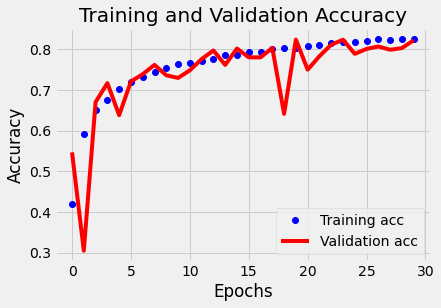

Training Accuracy: 0.8261500000953674
Validation Accuracy: 0.8220999836921692


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

# Plot Training vs. Validation
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"Training Accuracy: {acc[-1]}")
print(f"Validation Accuracy: {val_acc[-1]}")

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [14]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale= rescale,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip
)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train_vec, batch_size=batch_size)


model.compile(
    loss=loss,
    optimizer= optimizers.RMSprop(
        learning_rate= learning_rate,
        rho=rho,
        momentum=momentum),
    metrics = metrics
)

In [ ]:
history = model.fit(train_generator, epochs=ephochs)

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [ ]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))